In [159]:
import cv2
import numpy as np
import onnxruntime as ort
from collections import deque
from modelArc import CRNN
from itertools import groupby
from matplotlib import pyplot as plt
from skimage.filters import threshold_local
import torch

def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

def preprocess_image(image):
    # Load the image using OpenCV
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 4)
    # thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    # invert = 255 - opening

    return opening

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

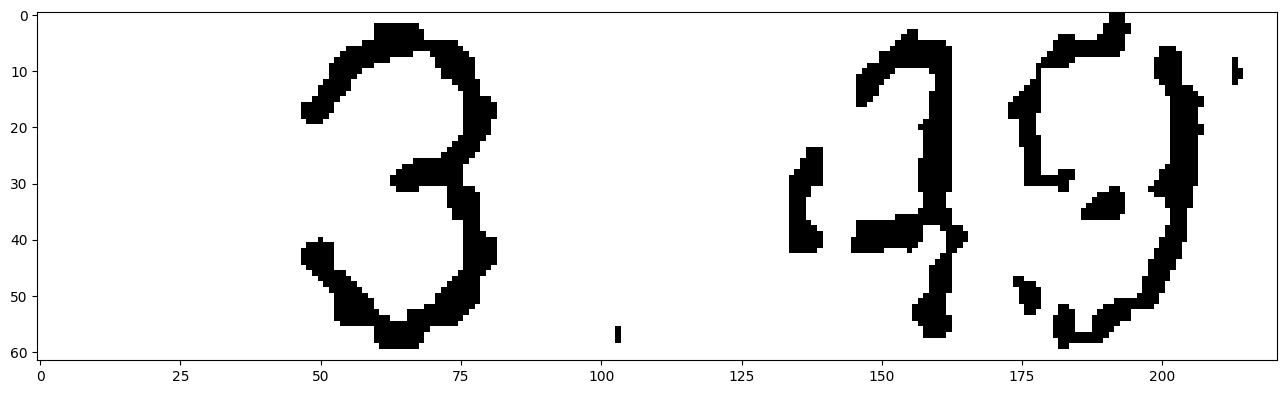

In [164]:
p = r"D:\photos\RCNN4\Lines\263-3.jpg"
testing = cv2.imread(p)
# display = bw_scanner(testing)
# display = cv2.cvtColor(testing, cv2.COLOR_BGR2GRAY)
display = preprocess_image(testing)
plot_gray(display)

In [36]:
model_path = r"D:\Projects\reciept-scanner\RCNN\models\GREYsmall\model.onnx"

class inferencemode:
    def __init__(self, model_path: str = ""):
        self.model_path = model_path.replace("\\", "/")
        providers = ["CUDAExecutionProvider", "CPUExecutionProvider"] if ort.get_device() == "GPU" else ["CPUExecutionProvider"]

        self.model = ort.InferenceSession(model_path, providers = providers)

        self.metadata = {}
        for key, value in self.model.get_modelmeta().custom_metadata_map.items():
            new_value = value
            self.metadata[key] = new_value

        self.input_shapes = [meta.shape for meta in self.model.get_inputs()]
        self.input_names = [meta.name for meta in self.model._inputs_meta]
        self.output_names = [meta.name for meta in self.model._outputs_meta]

    def preprocess(self, image: np.ndarray):
        # Load the image using OpenCV
        blur = cv2.GaussianBlur(image, (3,3), 0)

        thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        invert = 255 - opening

        return invert

    def predict(self, image: np.ndarray):
        image = cv2.resize(image, (128, 32))

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)
        image_pred = np.expand_dims(image_pred, axis=1)

        preds = self.model.run(self.output_names, {self.input_names[0]: image_pred})[0]

        #highest prob
        argmax_preds = np.argmax(preds, axis=-1)
        grouped_preds = [[k for k,_ in groupby(preds)] for preds in argmax_preds]
        texts = ["".join([self.metadata["vocab"][k] for k in group if k < len(self.metadata["vocab"])]) for group in grouped_preds]
        text = texts[0]

        return text
    
    def run(self, image: np.ndarray, bbox_coords: list): #list of format [[xmin, xmax, ymin, ymax], [xmin, xmax, ymin, ymax], [xmin, xmax, ymin, ymax],....]
        bboxes = []
        for i, (x_min, x_max, y_min, y_max) in enumerate(bbox_coords):
            box = image[y_min:y_max, x_min:x_max,]
            bboxes.append(box)
        
        results = []
        for b in bboxes:

            plt.figure(figsize=(10, 2))
            plt.imshow(b, cmap='gray')

            grey_image = self.preprocess(b)
            img_height, img_width = grey_image.shape[:2]

            minWidth = int(img_width * 0.05)
            minHeight = int(img_height * 0.25)
            minContourArea = int(img_width * img_height * 0.0015)

            # cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
            _, binary_image = cv2.threshold(grey_image, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
            kernel = np.ones((3, 17), np.uint8)
            dilated_image = cv2.dilate(binary_image, kernel, iterations=2)

            start_x = img_width * 3 // 4 
            roi = dilated_image[:, start_x:]
            kernel = np.ones((5, 36), np.uint8)
            dilated_roi = cv2.dilate(roi, kernel, iterations=1)
            dilated_image[:, start_x:] = dilated_roi

            contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            filtered_contours = [c for c in contours if cv2.contourArea(c) > minContourArea]
            bounding_boxes = [cv2.boundingRect(c) for c in filtered_contours]
            bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])

            elements = []
            for i, (x, y, w, h) in enumerate(bounding_boxes):
                if w > minWidth and h> minHeight:
                    line_image = grey_image[y:y+h, x:x+w]
                    elements.append(line_image)

            text = []
            for capture in elements:
                mean = 198.87491
                std = 105.648796
                img_tensor = torch.tensor(capture, dtype=torch.float32)
                norm_img = (img_tensor - mean) / std
                processed_capture = norm_img.numpy()
                prediction_text = self.predict(processed_capture)
                text.append(prediction_text)
            results.append(text)

            for (x, y, w, h) in bounding_boxes:
                if w > minWidth and h> minHeight:
                    cv2.rectangle(b, (x, y), (x+w, y+h), (0, 255, 0), 2)
            # Plot the image with bounding boxes
            plt.figure(figsize=(10, 2))
            plt.imshow(b, cmap='gray')
            plt.title('Detected Lines')
            plt.axis('off')
            plt.show()
            print(text)
        return results #results is a [[item: str], [item: str], [item: str], [item: str]....]

(4032, 1816)


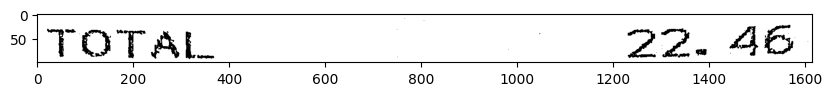

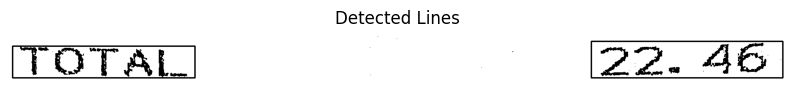

['22.46', 'TOTAL']


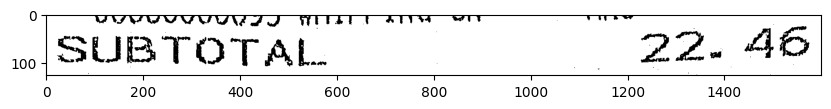

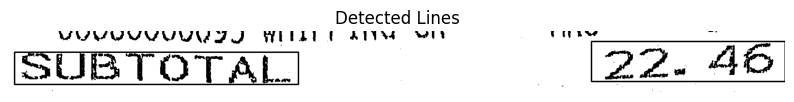

['22.46', 'SUBTOTAL']


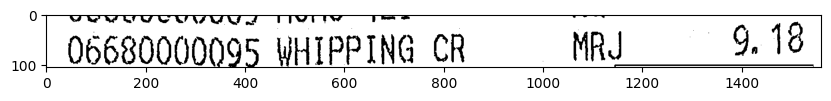

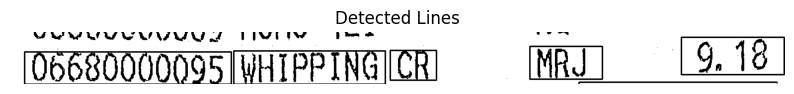

['9.18', 'MM)', 'CR', 'WMIPRING', '066600000095']


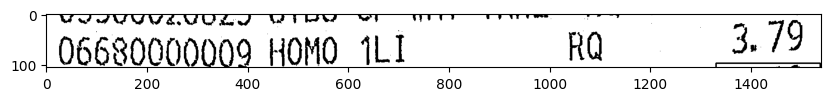

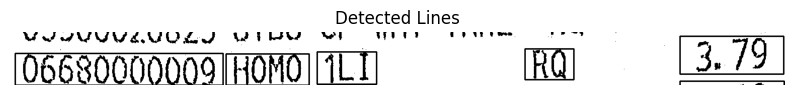

['3.79', 'RD', '1L', '066600000009', 'MDWID']


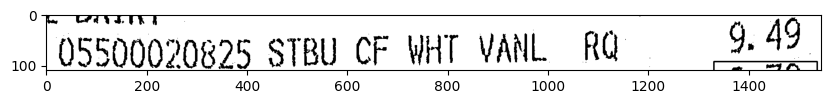

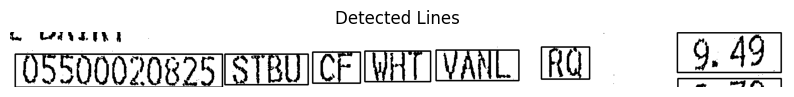

['9.49', 'RD', 'WAAL', 'NMT', 'CE', 'STAD', '0550002025']
['22.46', 'TOTAL']
['22.46', 'SUBTOTAL']
['9.18', 'MM)', 'CR', 'WMIPRING', '066600000095']
['3.79', 'RD', '1L', '066600000009', 'MDWID']
['9.49', 'RD', 'WAAL', 'NMT', 'CE', 'STAD', '0550002025']


In [39]:
#overall function
# testing
bboxCoord = [[105, 1720, 1415, 1515], [105, 1705, 1235, 1360], [160, 1720, 1155, 1260], [180, 1720, 1070, 1175], [180, 1725, 985, 1095]]
mean = 198.89307
std = 105.63787
img_path = r"D:\photos\RCNN4\train\20240706_015503_jpg.rf.480d069b4a243d281112d1daf06b8862.jpg"
image = cv2.imread(img_path.replace("\\", "/"))
img = bw_scanner(image)
print(img.shape)

tester = inferencemode(model_path)

results = tester.run(img, bboxCoord)
for i in results:
    print(i)


In [29]:
img_path = r"D:\photos\RCNN4\BBOXES\75.jpg"
# img_path = r"D:\photos\SORIE\test\0afc0804-7e6e-4e77-ab68-8d9384918be7.jpg"
# img_path = r"D:\photos\SORIE\test\000b7973-43d8-4071-bcdd-0274f6422771.jpg"


image = cv2.imread(img_path.replace("\\", "/"))#np array
image = bw_scanner(image)
img_tensor = torch.tensor(image, dtype=torch.float32)
norm_img = (img_tensor - mean) / std
image = norm_img.numpy()
model = inferencemode(model_path)
prediction_text = model.predict(image)
print(f"Prediction is: {prediction_text}")

Prediction is: T 149


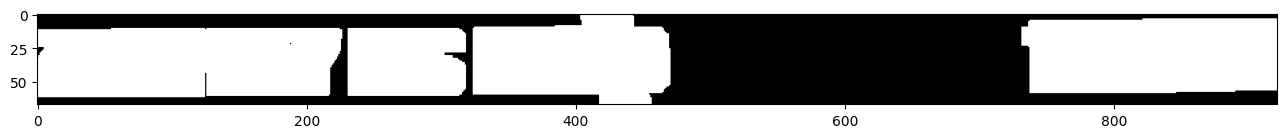

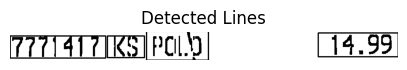

Prediction is: (PL0
Prediction is: 14.99
Prediction is: ES
Prediction is: 77114117


In [38]:
img_path = r"D:\photos\RCNN4\BBOXES\95.jpg"
img_path = r"D:\photos\RCNN_new_data\bboxes\items\1141.jpg"
# img_path = r"D:\photos\SORIE\train\f3652815-bdf8-43f3-b017-093e99cee5fa.jpg"

image = cv2.imread(img_path.replace("\\", "/"))#np array
img_height, img_width = image.shape[:2]

minWidth = int(img_width * 0.05)
minHeight = int(img_height * 0.25)
minContourArea = int(img_width * img_height * 0.0015)

image = bw_scanner(image)
image_finder = preprocess_image(image)

_, binary_image = cv2.threshold(image_finder, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
kernel = np.ones((3, 17), np.uint8)
dilated_image = cv2.dilate(binary_image, kernel, iterations=2)

start_x = img_width * 3 // 4 
roi = dilated_image[:, start_x:]
kernel = np.ones((5, 36), np.uint8)
dilated_roi = cv2.dilate(roi, kernel, iterations=1)
dilated_image[:, start_x:] = dilated_roi

plot_gray(dilated_image)
contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered_contours = [c for c in contours if cv2.contourArea(c) > minContourArea]

bounding_boxes = [cv2.boundingRect(c) for c in filtered_contours]
bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])

elements = []
color_image = image_finder
for i, (x, y, w, h) in enumerate(bounding_boxes):
    if w > minWidth and h>minHeight:
        line_image = color_image[y:y+h, x:x+w]
        elements.append(line_image)

model = inferencemode(model_path)
for (x, y, w, h) in bounding_boxes:
    if w > minWidth and h>minHeight:
        cv2.rectangle(color_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
# Plot the image with bounding boxes
plt.figure(figsize=(5, 1))
plt.imshow(color_image, cmap='gray')
plt.title('Detected Lines')
plt.axis('off')
plt.show()

for capture in elements:
    img_tensor = torch.tensor(capture, dtype=torch.float32)
    norm_img = (img_tensor - mean) / std
    i = norm_img.numpy()
    prediction_text = model.predict(i)
    print(f"Prediction is: {prediction_text}")